这个demo的目的是告诉大家，如何在sagemaker使用script模式训练tensorflow模型

首先我们先准备训练数据，这个例子中我们使用最简单MNIST数据集来进行训练
我们首先下载MNIST数据集并且将其解析为numpy array数据

In [1]:
import pickle, gzip, urllib.request, json
import numpy as np

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
print(valid_set[1].shape)

(10000,)


然后通过matplotlib展示下数据

This is a 5


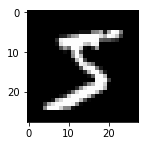

This is a 0


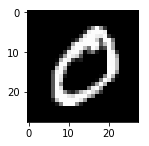

This is a 4


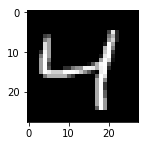

This is a 1


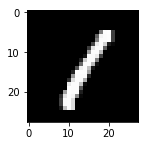

This is a 9


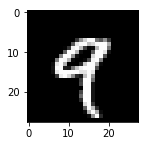

This is a 2


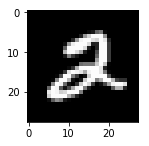

This is a 1


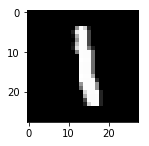

This is a 3


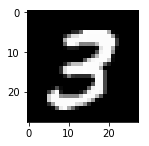

This is a 1


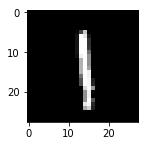

This is a 4


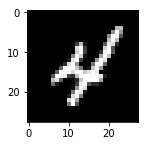

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (2,10)

for i in range(0, 10):
    img = train_set[0][i]
    label = train_set[1][i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()

这一步我们将刚才numpy数据转换成CSV文件并上传到一个S3的存储桶中

我们通过prefix的方式组织train、validation和test数据

In [3]:
%%time

import os
import boto3
import re
import copy
import time
import io
import struct
from time import gmtime, strftime
from sagemaker import get_execution_role

role = get_execution_role()

region = boto3.Session().region_name

bucket='sagemaker-mnist-datasets' # Replace with your s3 bucket name
prefix = 'tf-mnist' # Used as part of the path in the bucket where you store data
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket) # The URL to access the bucket


def convert_data():
    data_partitions = [('train', train_set), ('validation', valid_set), ('test', test_set)]
    for data_partition_name, data_partition in data_partitions:
        print('{}: {} {}'.format(data_partition_name, data_partition[0].shape, data_partition[1].shape))
        labels = [t.tolist() for t in data_partition[1]]
        features = [t.tolist() for t in data_partition[0]]
        
        if data_partition_name != 'test':
            examples = np.insert(features, 0, labels, axis=1)  # 在feature矩阵的第0列插入labels
        else:
            examples = features  # test数据集没有把labels加进去，why？
        #print(examples[50000,:])
        
        
        np.savetxt('data.csv', examples, delimiter=',')
        
        
        
        key = "{}/{}/examples".format(prefix,data_partition_name)
        url = 's3://{}/{}'.format(bucket, key)
        boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_file('data.csv')
        print('Done writing to {}'.format(url))
        
convert_data()

train: (50000, 784) (50000,)
Done writing to s3://sagemaker-mnist-datasets/tf-mnist/train/examples
validation: (10000, 784) (10000,)
Done writing to s3://sagemaker-mnist-datasets/tf-mnist/validation/examples
test: (10000, 784) (10000,)
Done writing to s3://sagemaker-mnist-datasets/tf-mnist/test/examples
CPU times: user 31.2 s, sys: 3.62 s, total: 34.8 s
Wall time: 41.9 s


定义各个数据集的S3 URL

In [4]:
train_data = 's3://{}/{}/{}'.format(bucket, prefix, 'train')

validation_data = 's3://{}/{}/{}'.format(bucket, prefix, 'validation')

s3_output_location = 's3://{}/{}/{}'.format(bucket, prefix, 'tf-mninst-output')
print(train_data)

s3://sagemaker-mnist-datasets/tf-mnist/train


定义用于训练和验证的数据集Channel，一会儿会作为参数传个训练任务

In [5]:
data_channels = {'train': train_data, 'validation': validation_data}
print(data_channels)

{'train': 's3://sagemaker-mnist-datasets/tf-mnist/train', 'validation': 's3://sagemaker-mnist-datasets/tf-mnist/validation'}


在sagemaker上进行分布式训练，需要在创建estimator时指定distributions参数，我们用的是horovod，是基于open mpi技术；此外还需要指定instance_count，当这个数字大于1时，sagemaker会调用mpirun命令进行训练

In [6]:
import sagemaker
from sagemaker.tensorflow import TensorFlow

distributions = {'mpi': {'enabled': True}}
instance_count = 2

model_dir = '/opt/ml/model'
# train_instance_type = 'local'
train_instance_type = 'ml.m5.xlarge'
# train_instance_type = 'ml.p3.2xlarge'
hyperparameters = {'epochs': 20, 'batch_size': 128, 'learning_rate': 0.01, 'other_para':0.1}
# 如果需要监控训练算法中某一个指标，可以定义metric_definitions并传入Tensorflow estimator，被监控的metrics会被解析并打到cloudwatch
metric_definitions = [{'Name': 'accuracy',
                       'Regex': 'accuracy=(.*?);'}]

tf_estimator = TensorFlow(
                       entry_point='horovod_train.py',
                       model_dir=model_dir,
                       output_path=s3_output_location,
                       train_instance_type=train_instance_type,
                       train_instance_count=instance_count,
                       distributions=distributions,
                       hyperparameters=hyperparameters,
                       role=sagemaker.get_execution_role(),
                       base_job_name='tf-scriptmode-mnist',
                       framework_version='2.0.0',
                       py_version='py3',
                       metric_definitions=metric_definitions,
                       script_mode=True,)

In [ ]:
%%time
tf_estimator.fit(inputs=data_channels)

2020-03-04 14:12:24 Starting - Starting the training job...
2020-03-04 14:12:25 Starting - Launching requested ML instances...
2020-03-04 14:13:19 Starting - Preparing the instances for training......
2020-03-04 14:14:09 Downloading - Downloading input data...
2020-03-04 14:14:47 Training - Training image download completed. Training in progress..2020-03-04 14:14:50,119 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-03-04 14:14:50,124 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-03-04 14:14:50,359 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-03-04 14:14:51,799 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-03-04 14:14:51,811 sagemaker-containers INFO     Starting MPI run as worker node.
2020-03-04 14:14:51,811 sagemaker-containers INFO     Waiting for MPI Master to create SSH daemon.
2020-03-04 14:14:51,817 paramiko.transport INFO  

In [ ]:
tf_predictor = tf_estimator.deploy(initial_instance_count=1,instance_type='ml.m5.xlarge')

---------------------------------------------------

验证一下测试数据集的预测结果和真实label的对比

通过np.argmax方法得到一个softmax后的输出的预测结果

In [20]:
import numpy as np
results = tf_predictor.predict(test_set[0][:10]/255)['predictions']

flat_list = [np.argmax(sublist) for sublist in results]
print('predictions: \t{}'.format(flat_list))
print('target values: \t{}'.format(list(test_set[1][:10])))

predictions: 	[7, 2, 1, 0, 4, 1, 4, 7, 6, 9]
target values: 	[7, 2, 1, 0, 4, 1, 4, 9, 5, 9]


In [21]:
tf_predictor.delete_endpoint()

在定义distributions参数时，还有一个属性控制有多少个process运行training任务，如果要利用到GPU的多卡属性，需要在定义"processes_per_host"属性的值等于单机GPU的数量（或者小于单机GPU的数量也可以，只不过有GPU会利用不到，具体容器可见的GPU的数量，是可以在训练代码中绑定的）

In [33]:
#distributions = {'mpi': {'enabled': True, "processes_per_host": 2}}
distributions = {'mpi': {'enabled': True}}
# train_instance_type = 'ml.m5.xlarge'
train_instance_type = 'ml.p3.8xlarge'

instance_count = 2

hyperparameters = {'epochs': 2, 'batch_size': 128, 'learning_rate': 0.01, 'other_para':0.1}

tf_estimator_multi_processers = TensorFlow(
                       entry_point='horovod_train.py',
                       model_dir=model_dir,
                       output_path=s3_output_location,
                       train_instance_type=train_instance_type,
                       train_instance_count=instance_count,
                       distributions=distributions,
                       hyperparameters=hyperparameters,
                       role=sagemaker.get_execution_role(),
                       base_job_name='tf-scriptmode-mnist',
                       framework_version='2.0.0',
                       py_version='py3',
                       metric_definitions=metric_definitions,
                       script_mode=True,)

In [34]:
%%time
tf_estimator_multi_processers.fit(inputs=data_channels)

2020-03-09 09:38:03 Starting - Starting the training job...
2020-03-09 09:38:04 Starting - Launching requested ML instances...
2020-03-09 09:38:59 Starting - Preparing the instances for training.........
2020-03-09 09:40:13 Downloading - Downloading input data...
2020-03-09 09:41:01 Training - Training image download completed. Training in progress..2020-03-09 09:41:05,508 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-03-09 09:41:05,918 sagemaker-containers INFO     Starting MPI run as worker node.
2020-03-09 09:41:05,918 sagemaker-containers INFO     Waiting for MPI Master to create SSH daemon.
2020-03-09 09:41:05,925 paramiko.transport INFO     Connected (version 2.0, client OpenSSH_7.6p1)
/usr/local/lib/python3.6/dist-packages/paramiko/kex_ecdh_nist.py:39: CryptographyDeprecationWarning: encode_point has been deprecated on EllipticCurvePublicNumbers and will be removed in a future version. Please use EllipticCurvePublicKey.public_bytes

In [35]:
# enable network isolation
tf_estimator_isolated = TensorFlow(
                       entry_point='horovod_train.py',
                       model_dir=model_dir,
                       output_path=s3_output_location,
                       train_instance_type=train_instance_type,
                       train_instance_count=instance_count,
                       distributions=distributions,
                       hyperparameters=hyperparameters,
                       role=sagemaker.get_execution_role(),
                       base_job_name='tf-scriptmode-mnist',
                       framework_version='2.0.0',
                       py_version='py3',
                       metric_definitions=metric_definitions,
                       script_mode=True,
                       enable_network_isolation=True)

In [9]:
%%time
tf_estimator_isolated.fit(inputs=data_channels)

2020-03-09 03:50:53 Starting - Starting the training job...
2020-03-09 03:50:54 Starting - Launching requested ML instances...
2020-03-09 03:51:52 Starting - Preparing the instances for training......
2020-03-09 03:52:45 Downloading - Downloading input data...
2020-03-09 03:53:18 Training - Downloading the training image..2020-03-09 03:53:35,036 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-03-09 03:53:35,042 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-03-09 03:53:35,064 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-03-09 03:53:35,078 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-03-09 03:53:35,088 sagemaker-containers INFO     Starting MPI run as worker node.
2020-03-09 03:53:35,088 sagemaker-containers INFO     Creating SSH daemon.
2020-03-09 03:53:35,093 sagemaker-containers INFO     Waiting for MPI workers to establish their S